In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('stock-amazon.csv')

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

data = df.sort_index(ascending=True, axis=0)

train_len = int(len(data) * 0.75)

In [2]:
df.head()

,Date,high-AMZN,low-AMZN,open-AMZN,close-AMZN,volume-AMZN,adj-close-AMZN
Date,,,,,,,
2014-01-02,2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001
2014-01-03,2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002
2014-01-06,2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005
2014-01-07,2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999
2014-01-08,2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013


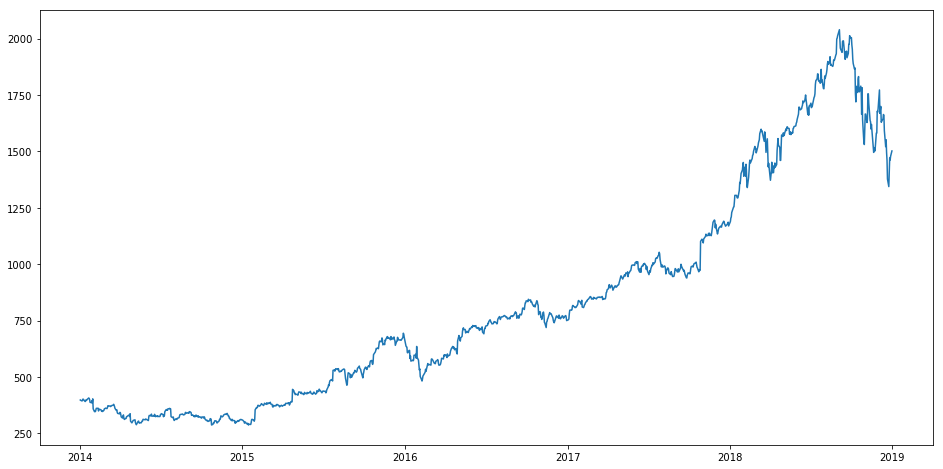

In [3]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df['adj-close-AMZN'], label='Close Price history')

# Liner_model to predict stock prices

In [4]:
# creating dataframe with date and the target variable
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Volume', 'Close'])

In [5]:
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Volume'][i] = data['volume-AMZN'][i]
     new_data['Close'][i] = data['adj-close-AMZN'][i]

In [6]:
import re
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)

In [7]:
# Add year, month, week, day & date related information
add_datepart(new_data, 'Date')

In [8]:
new_data.head()

,Volume,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2137800,397.97,2014,1,1,2,3,2,False,False,False,False,False,False
1,2210200,396.44,2014,1,1,3,4,3,False,False,False,False,False,False
2,3170600,393.63,2014,1,2,6,0,6,False,False,False,False,False,False
3,1916000,398.03,2014,1,2,7,1,7,False,False,False,False,False,False
4,2316500,401.92,2014,1,2,8,2,8,False,False,False,False,False,False


In [9]:
#split into train and validation
train = new_data[:train_len]
valid = new_data[train_len:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

487.5276427562748

/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


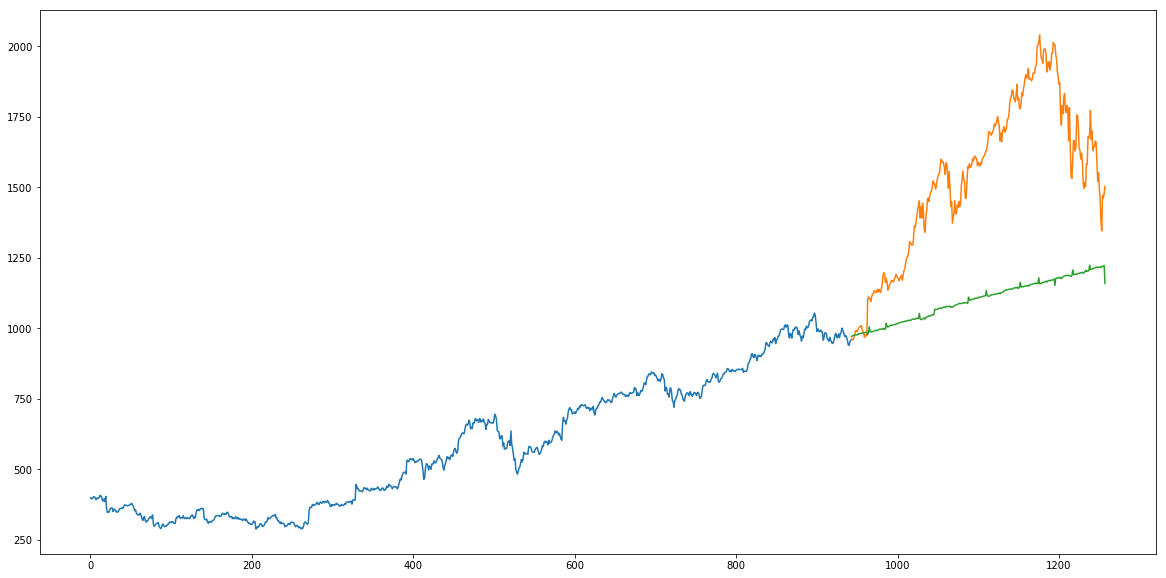

In [11]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[train_len:].index
train.index = new_data[:train_len].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

# Use kNN to predict stock price

In [12]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)


/Users/yanjingding/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/yanjingding/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/yanjingding/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

767.3836171779335

/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


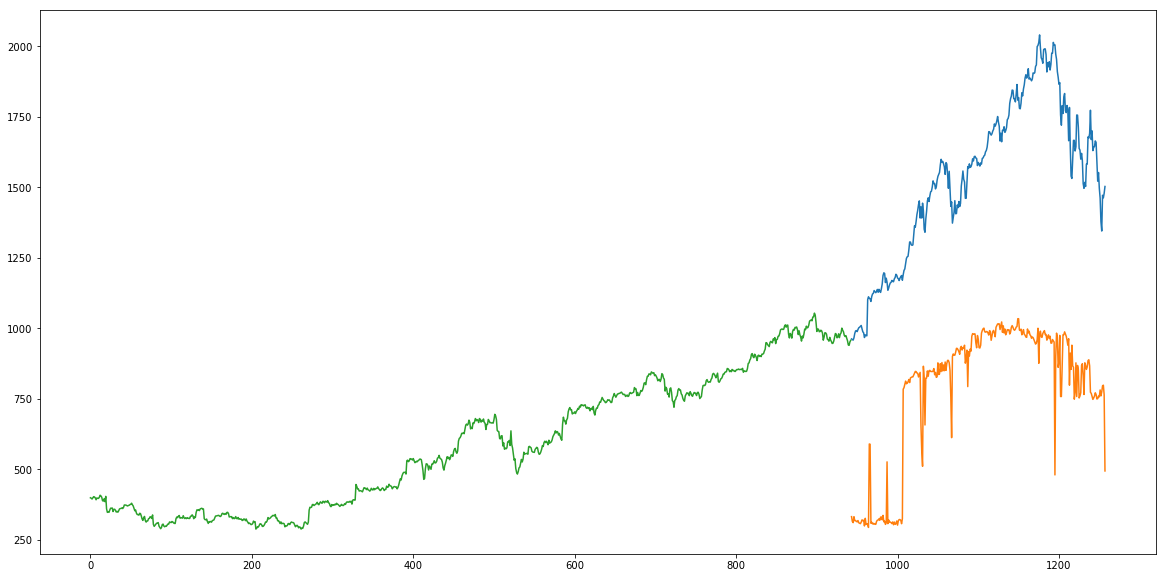

In [14]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

# Use Random forest to predict stock price

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,f1_score

model = RandomForestRegressor(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)


In [16]:
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
preds = model.predict(x_valid)

In [18]:
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

739.033670625464

/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


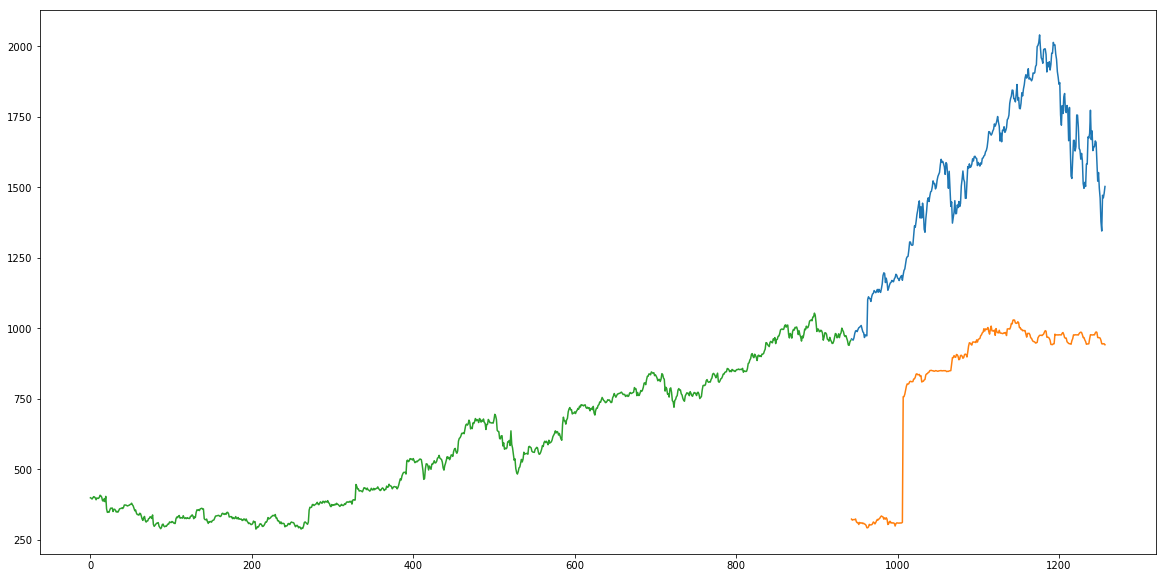

In [19]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

# Use auto ARIMA

In [20]:
from pyramid.arima import auto_arima

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=len(validation))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=7581.803, BIC=7591.474, Fit time=0.066 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=7271.295, BIC=7290.636, Fit time=1.033 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=6953.062, BIC=6972.403, Fit time=1.402 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=6952.542, BIC=6976.718, Fit time=2.138 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=7271.295, BIC=7290.636, Fit time=0.946 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=6957.900, BIC=6986.911, Fit time=8.528 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=7583.658, BIC=7598.163, Fit time=0.273 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=6959.120, BIC=6992.966, Fit time=5.153 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_orde

In [21]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

435.9597950005289

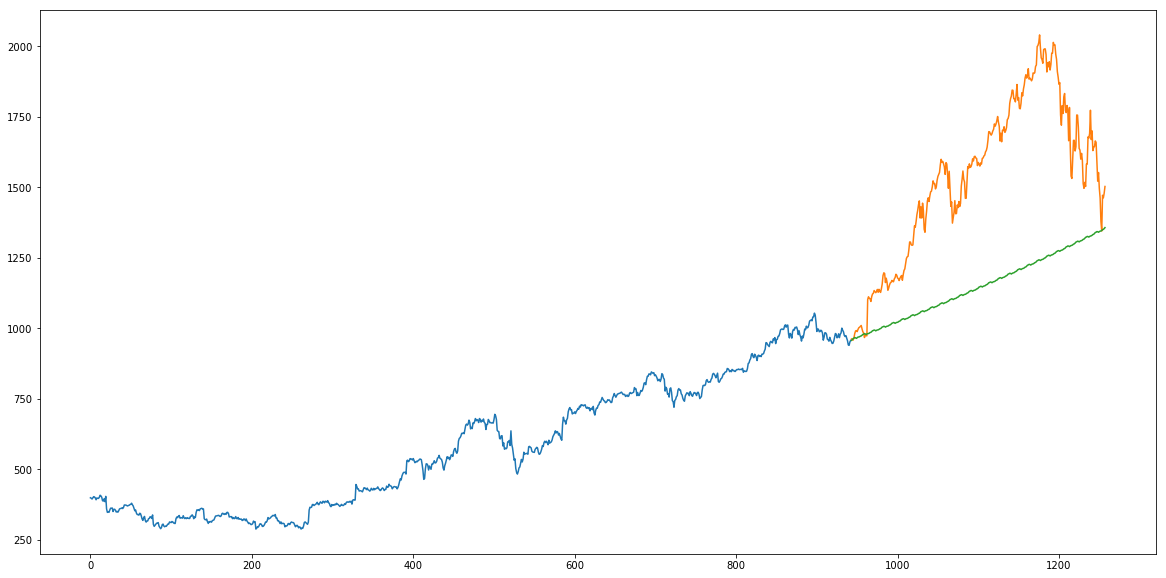

In [22]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

# LSTM to predict

In [2]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

new_data2 = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data2['Date'][i] = data['Date'][i]
    new_data2['Close'][i] = data['adj-close-AMZN'][i]

#setting index
new_data2.index = new_data2.Date
new_data2.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data2.values

train = dataset[0:train_len,:]
valid = dataset[train_len:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(5,len(train)):
    x_train.append(scaled_data[i-5:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

/Users/yanjingding/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/yanjingding/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
#predicting values, using past 5 from the train data
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 22s - loss: 9.7251e-04


In [4]:
inputs = new_data2[len(new_data2) - len(valid) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(5,inputs.shape[0]):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

89.54033363788739

/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


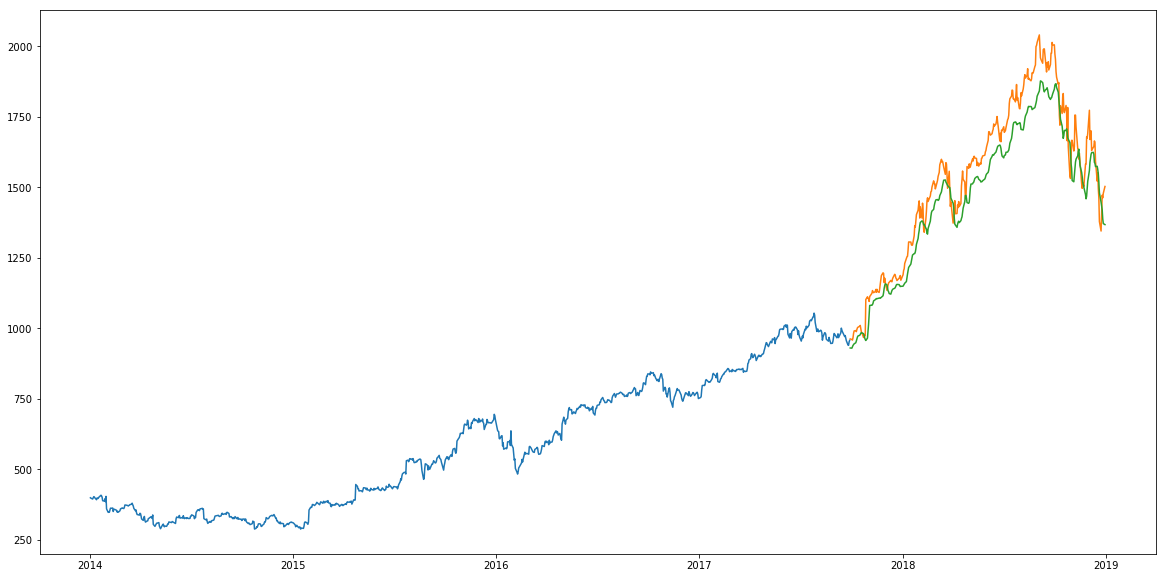

In [5]:
#for plotting
train = new_data2[:train_len]
valid = new_data2[train_len:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
